Questions to answer by this EDA:
- What kind of data do we have? 
    - What kind of raw data do we have? \[x]
    - How big is the dataset?   \[x]
- How does l5kit work?
    - What kind of abstractions does l5kit provide? \[x]
    - Can we combine zarr files?
    - What information does the rasterizer encode and what does it miss? Does it encode agent type?
- General visualization and analysis
    - How is the data distributed?
    - Is the data complete?
    - Does the data need any cleaning?

In [17]:
import numpy as np
import pandas
import l5kit

from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset

from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data
from l5kit.visualization import draw_trajectory, TARGET_POINTS_COLOR, REFERENCE_TRAJ_COLOR 
from l5kit.geometry import transform_points
from tqdm import tqdm
from collections import Counter
from l5kit.data import PERCEPTION_LABELS
from prettytable import PrettyTable
import matplotlib.pyplot as plt

In [18]:
os.environ["L5KIT_DATA_FOLDER"] = "/home/elias/Documents/lyft-motion-prediction/data"

cfg = load_config_data("./eda_config.yaml")

print(f'current raster_param:\n')
for k,v in cfg["raster_params"].items():
    print(f"{k}:{v}")


current raster_param:

raster_size:[224, 224]
pixel_size:[0.5, 0.5]
ego_center:[0.25, 0.5]
map_type:py_semantic
satellite_map_key:aerial_map/aerial_map.png
semantic_map_key:semantic_map/semantic_map.pb
dataset_meta_key:meta.json
filter_agents_threshold:0.5
disable_traffic_light_faces:False


# Loading the data

In [19]:
dm = LocalDataManager()
sample_dataset_path = dm.require(cfg["sample_data_loader"]["key"])
train_dataset_path = dm.require(cfg["train_data_loader"]["key"])
validate_dataset_path = dm.require(cfg["val_data_loader"]["key"])

zarr_dataset = ChunkedDataset(sample_dataset_path)
train_dataset = ChunkedDataset(train_dataset_path)
validate_dataset = ChunkedDataset(validate_dataset_path)

print("SAMPLE DATASET")
zarr_dataset.open()
print(zarr_dataset)

print("TRAINING DATASET")
train_dataset.open()
print(train_dataset)

print("VALIDATION DATASET")
validate_dataset.open()
print(validate_dataset)

SAMPLE DATASET
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
TRAINING DATASET
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+------------------

The validation dataset seems to be just as large as the training dataset. For training of the final model, this data should definately be included in training

# What kind of data do we have?

In this data, l5kit provides four structured arrays that contain data. These are Scenes, frames, agents and traffic light faces. Text and data type information taken from the official [l5kit](https://github.com/lyft/l5kit) repository.

## Scenes

First we look at scenes. A scene is identified by the ego vehicle who collected the data, as well as a start and end time. It thus consists of many frames that make up that scene. The start and end inded of these frames are stored in the scene datatype.

```python
SCENE_DTYPE = [
    ("frame_index_interval", np.int64, (2,)),
    ("host", "<U16"),  # Unicode string up to 16 chars
    ("start_time", np.int64),
    ("end_time", np.int64),
]
```

## Frames
Next we have frame. A frame captures all the information observed at the specific time. This includes:
- Timestap
- data about the ego vehicle (rotation and position)
- Reference to other agents captured by the sensors (a pointer)
- Reference to all traffic light faces in the visible lanes

```python
FRAME_DTYPE = [
    ("timestamp", np.int64),
    ("agent_index_interval", np.int64, (2,)),
    ("traffic_light_faces_index_interval", np.int64, (2,)),
    ("ego_translation", np.float64, (3,)),
    ("ego_rotation", np.float64, (3, 3)),
]
```


## Agents

An agent is an observed object that was detected by the ego vehicle. each agent object contains information such as position, velocity, and a tracking number to keep track of it over multiple frames (within one scene). The most probable label is also included. This label should be important information to give the neural network, as a car, pedestrian, and bicyclist will behave quite differently in the traffic.  

```
AGENT_DTYPE = [
    ("centroid", np.float64, (2,)),
    ("extent", np.float32, (3,)),
    ("yaw", np.float32),
    ("velocity", np.float32, (2,)),
    ("track_id", np.uint64),
    ("label_probabilities", np.float32, (len(LABELS),)),
]
```

## Traffic Light Faces

The semantic map only holds static information about the world. So it has a list of all traffic lights, but not their current status. This type of information is stored in this traffic light face object. if status >0, it is active. NOTE: a traffic light face is a specific light bulb, like the red light bulb of a specific traffic light.
```
TL_FACE_DTYPE = [
    ("face_id", "<U16"),
    ("traffic_light_id", "<U16"),
    ("traffic_light_face_status", np.float32, (len(TL_FACE_LABELS,))),
]
```

# What abstractions does l5kit provide?

## Dataset classes

### EgoDataset

The EgoDataset retrieves information about the status of the AV in the current frame and the frames before it (if history is enabled). When iterated, it yields a dict with the following information:

| Field Name               | Description                                                                                                                                          |
|--------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------|
| `image`                  | The BEV raster as a multi-channel tensor                                                                                                             |
| `target_positions`       | The coordinates (in **agent** reference system) of the AV in the future. Unit is meters                                                         |
| `target_yaws`            | The yaws (in **agent** reference system) of the AV in the future. Unit is radians                                                       |
| `target_availabilities`  | A 1D array. Each item can be either 1 (future step is valid) or 0 (future step is not valid). Invalid steps may occur at the end or start of a scene |
| `history_positions`      | Same as target_positions but for the frames in the past                                                                                              |
| `history_yaws`           | Same as target_yaws but for the frames in the past                                                                                                   |
| `history_availabilities` | Same as target_availabilities but for the frames in the past                                                                                         |
| `raster_from_world`      | A 3x3 matrix mapping from world to the image reference system                                                                                        |
| `raster_from_agent`      | A 3x3 matrix mapping from agent to the image reference system                                                                                        |
| `agent_from_world`       | A 3x3 matrix mapping from world to the agent reference system                                                                                        |
| `world_from_agent`       | A 3x3 matrix mapping from agent to the world reference system                                                                                        |
| `track_id`               | A scene-unique identifier id for the agent, or -1 for the AV                                                                                         |
| `timestamp`              | The timestamp of the current frame                                                                                                                   |
| `centroid`               | The centroid of the AV in the current frame in **world** reference system. Unit is meters                                                            |
| `yaw`                    | The angle of yaw of the AV in the current frame in **world** reference system. Unit is radians                                                                                     |
| `extent`                 | The extent of the AV (in XYZ) in the world reference system. Unit is meters   



### AgentDataset

The AgentDataset iterates over agents (i.e. every other dynamic entity in the scene) instead of the AV. Because the returned dict is exactly the same as the EgoDataset, the two classes are almost interchangeable.

However, one fundamental difference exists: The AgentDataset is seeded with an agents_mask which defines which agents should be iterated over.

# Rasterizer

Time to look at the rasterizers provided by l5kit. Functions and visualizations taken from [corochann's l5 deep dive notebook](https://www.kaggle.com/corochann/lyft-deep-into-the-l5kit-library)

Lets see the different rasterization options we have

In [20]:
def visualize_rgb_image(dataset, index, title="", ax=None):
    """Visualizes Rasterizer's RGB image"""
    data = dataset[index]
    im = data["image"].transpose(1, 2, 0)
    im = dataset.rasterizer.to_rgb(im)

    if ax is None:
        fig, ax = plt.subplots()
    if title:
        ax.set_title(title)
    ax.imshow(im[::-1])

In [21]:
# Prepare all rasterizer and EgoDataset for each rasterizer
rasterizer_dict = {}
dataset_dict = {}

rasterizer_type_list = ["py_satellite", "satellite_debug", "py_semantic", "semantic_debug", "box_debug", "stub_debug"]

for i, key in enumerate(rasterizer_type_list):
    # print("key", key)
    cfg["raster_params"]["map_type"] = key
    rasterizer_dict[key] = build_rasterizer(cfg, dm)
    dataset_dict[key] = EgoDataset(cfg, zarr_dataset, rasterizer_dict[key])

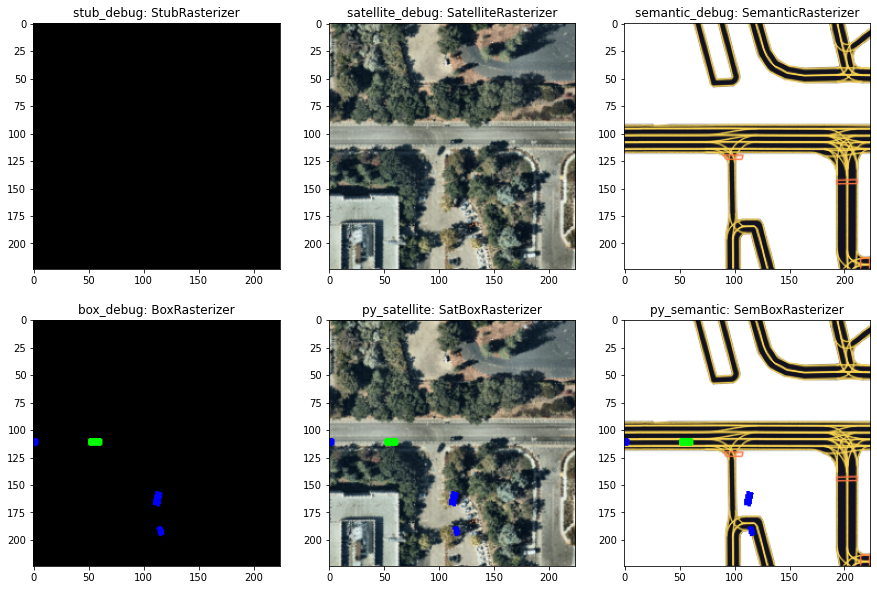

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for i, key in enumerate(["stub_debug", "satellite_debug", "semantic_debug", "box_debug", "py_satellite", "py_semantic"]):
    visualize_rgb_image(dataset_dict[key], index=0, title=f"{key}: {type(rasterizer_dict[key]).__name__}", ax=axes[i])
fig.show()

- `StubRasterizer` is just for debugging, creates all black image with specified (height, width).
- `BoxRasterizer` creates Ego (host car) as green box, and Agent as blue box. 
- `SatelliteRasterizer` draws satellite map. 
- `SemanticRasterizer` draws semantic map which contains lane and crosswalk information 
- `SatBoxRasterizer` = SatelliteRasterizer + BoxRasterizer
- `SemBoxRasterizer` = SemanticRasterizer + BoxRasterizer

In [32]:
# Rasterizer
cfg["raster_params"]["map_type"] = "py_semantic"
rast = build_rasterizer(cfg, dm)

# Dataset
dataset = EgoDataset(cfg, train_dataset, rast)  

print(rast)

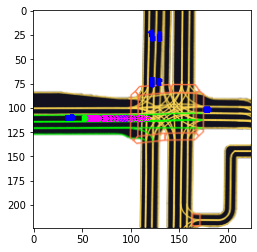

In [35]:
data = dataset[1500]
im = data["image"].transpose(1, 2, 0)
im = dataset.rasterizer.to_rgb(im)
target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])


draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=data["target_yaws"])


plt.imshow(im[::-1])
plt.show()

array([[255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255